In [1]:
#installing dependencies
pip install gym
pip install torch
pip install torchvision

  Stored in directory: C:\Users\saty\AppData\Local\pip\Cache\wheels\93\c2\4c\2b4c9b85119994837c08315c9415d71008325b7004d385b418
Successfully built gym
  Found existing installation: cloudpickle 0.8.0
    Uninstalling cloudpickle-0.8.0:
      Successfully uninstalled cloudpickle-0.8.0
Note: you may need to restart the kernel to use updated packages.


spyder 3.3.3 has requirement pyqt5<=5.12; python_version >= "3", but you'll have pyqt5 5.14.1 which is incompatible.


In [1]:
#Gym environment
import gym

env = gym.make('CartPole-v0')
env.reset()

for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
env.close()

D:\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


KeyboardInterrupt: 

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import functools
import operator

In [3]:
#IPython's display module is imported to aid us in plotting images to the screen later.
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

Now we will define a neural net that will act as target and policy net. 

In [ ]:
#target and policy net
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        input_dim=(3,img_height,img_width)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=32),
            nn.Linear(in_features=32, out_features=2),
        )

        
    def forward(self, t):
        batch_size = t.size(0)

        out = self.feature_extractor(t)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

Experiences from replay memory is what we'll use to train our network. To create experiences, we creating a class called Experience. This class will be used to create instances of Experience objects that will get stored in and sampled from replay memory later.

In [5]:
#Experiences 
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

ReplayMemory class is where these experiences will be stored.

In [6]:
#ReplayMemory class 
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

To get a balance of exploration and exploitation, we use an epsilon greedy strategy. With this strategy, we define an exploration rate called epsilon that we initially set to . This exploration rate is the probability that our agent will explore the environment rather than exploit it. 

In [1]:
#EpsilonGreedyStrategy
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)
    

Speaking of our agent, an Agent class is where we're headed next. Our Agent class will require a strategy and num_actions.

So, later when we create an Agent object, we'll need to already have an instance of EpsilonGreedyStrategy class created so that we can use that strategy to create our agent. num_actions corresponds to how many possible actions can the agent take from a given state. 

In [8]:

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    def select_action(self, state, policy_net, device):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

CartPoleEnvManager class will manage our cart and pole environment. It will wrap several of gym's environment capabilities, and it will also give us some added functionality, like image preprocessing, for the environment images that will be given to our network as input.

In [9]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    def reset(self):
        self.env.reset()
        self.current_screen = None
    def close(self):
        self.env.close()
    def render(self, mode='human'):
        return self.env.render(mode)
    def num_actions_available(self):
        return self.env.action_space.n
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    def just_starting(self):
        return self.current_screen is None
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

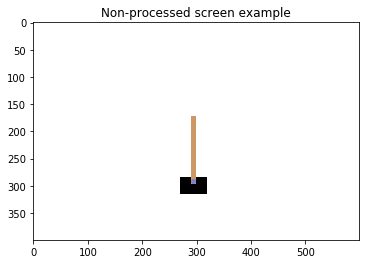

In [14]:
#Printing Non-Processed Screen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

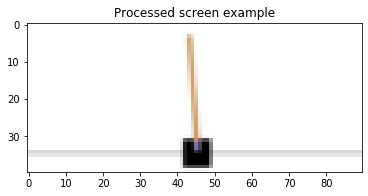

torch.Size([1, 3, 40, 90])


In [30]:
#Printing Processed Screen
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()
print(screen.size())

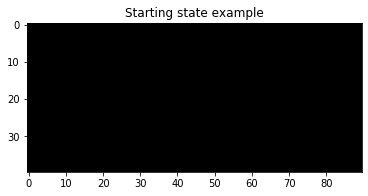

In [16]:
#Printing Starting State
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


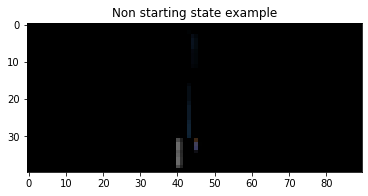

In [17]:
#Printing Non-Starting State
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

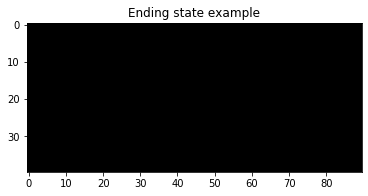

In [18]:
#Printing Ending Starting State
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

We're creating this function called plot() that accepts values and a moving average period. This plot will plot the duration of each episode, as well as the 100 episode moving average.

We'll also want to plot the 100 episode moving average, so we do so by calling the function get_moving_average(), which accepts the moving_average_period and the values for which it will be calculating the moving average from.

In [10]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

extract_tensors is the function that we called to extract all the states, actions, rewards, and next_states into their own tensors from a given batch of experiences.

In [11]:
#Tensor Processing
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

QValues is the class that we used to calculate the q-values for the current states using the policy_net, and the next states using the target_net.

This class contains two static methods, meaning that we're able to call these methods without creating an instance of the class first. Because we're creating the class in this way, we're setting up its own device since we won't be creating an instance of this class and passing in our device from our main program.

In [12]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

Within our main program, we're first initializing all of our hyperparameters.

Now, we'll set up all of the essential objects using the classes we've built in the previous episodes.
First though, let's set up our device for PyTorch. This tells PyTorch to use a GPU if it's available, otherwise use the CPU.
Now, we set up our environment manager em using the CartPoleEnvManager class, and we pass in the required device. We then set our strategy to be an instance of the EpsilonGreedyStrategy class, and we pass in the required start, end, and decay values for epsilon.
We then define an agent using our Agent class and pass in the required strategy, number of actions available, and device. We then initialize memory to be an instance of ReplayMemory and pass in the capacity using memory_size.Now, we define both our policy network and target network by creating two instances of our DQN class and passing in the height and width of the screen to set up the appropriate input shape of the networks. We put these networks on our defined device using PyTorch's to() function.We also put the target_net into eval mode, which tells PyTorch that this network is not in training mode. In other words, this network will only be used for inference.

In [13]:
batch_size = 256
gamma = 0.90
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

7740
7740


The steps that we'll be covering now in our main training loop:

1 Initialize replay memory capacity.

2 Initialize the policy network with random weights.

3 Clone the policy network, and call it the target network.

4 For each episode:

    1 Initialize the starting state.
    
    2 For each time step:

        1 Select an action.
        
            >>Via exploration or exploitation
            
        2 Execute selected action in an emulator.
        
        3 Observe reward and next state.
        
        4 Store experience in replay memory.
        
        5 Sample random batch from replay memory.
        
        6 Preprocess states from batch.
        
        7 Pass batch of preprocessed states to policy network.
        
        8 Calculate loss between output Q-values and target Q-values.
        
            >>Requires a pass to the target network for the next state
            
        Gradient descent updates weights in the policy network to minimize loss.

            >>After  time steps, weights in the target network are updated to the weights in the policy network.


In [14]:
#Training Loop
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net,device)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

KeyboardInterrupt: 